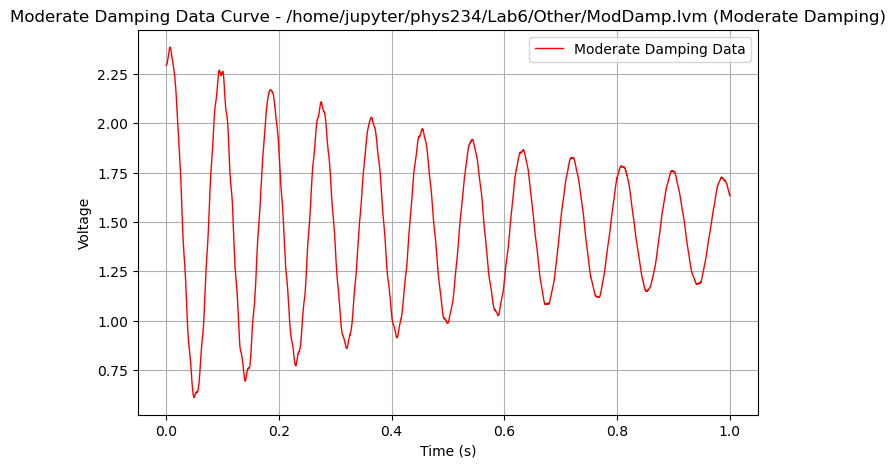

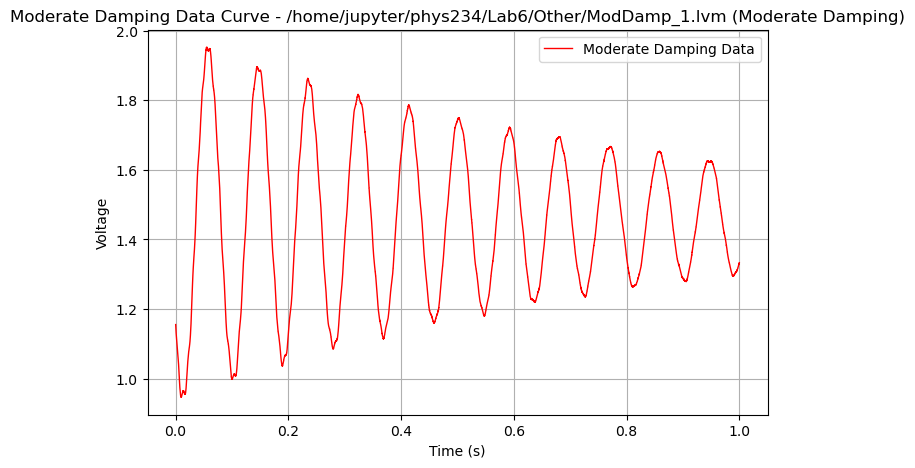

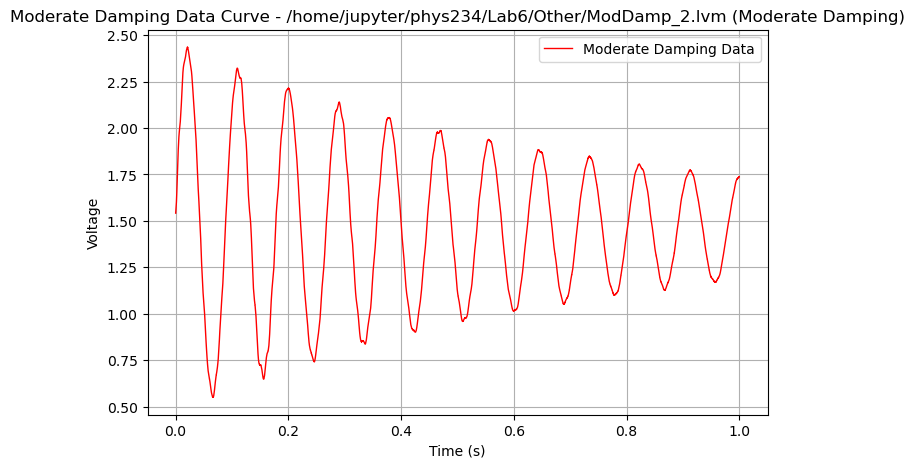

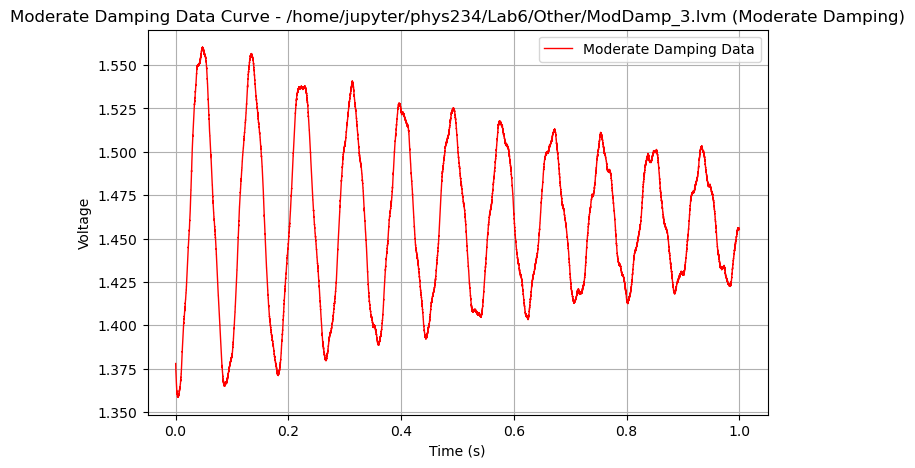

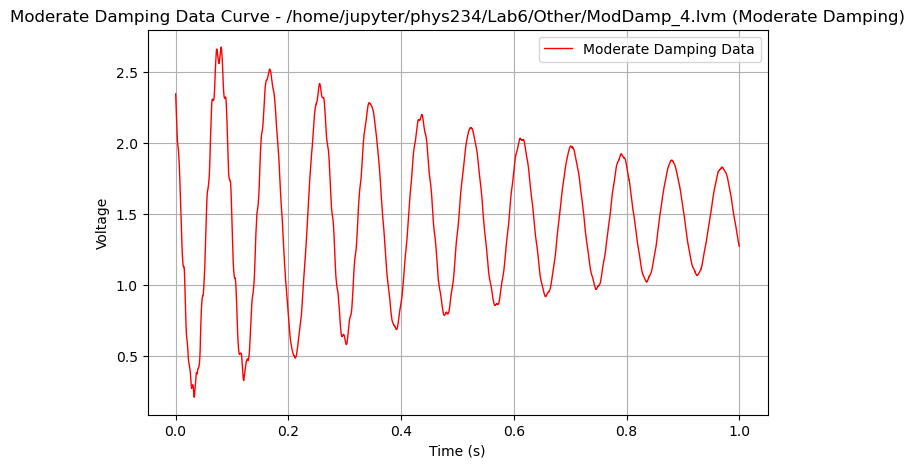

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define file paths max damping level
mod_damp_files = ["ModDamp.lvm", "ModDamp_1.lvm", "ModDamp_2.lvm", "ModDamp_3.lvm", "ModDamp_4.lvm"]
data_dir = "/home/jupyter/phys234/Lab6/Other/"  # Adjust as needed
mod_damp_files = [os.path.join(data_dir, fname) for fname in mod_damp_files]

# Function to plot original data curves
def plot_original_data(file_paths, damping_type):
    for file in file_paths:
        df = pd.read_csv(file, sep="\t", names=["Time", "Value1", "Value2"])
        plt.figure(figsize=(8, 5))
        plt.plot(df["Time"], df["Value1"], label="Moderate Damping Data", color="red", linewidth=1)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage")
        plt.legend()
        plt.title(f"Moderate Damping Data Curve - {file} ({damping_type} Damping)")
        plt.grid()
        plt.show()

# Plot original data for max damping level
plot_original_data(mod_damp_files, "Moderate")

# SLICE ANALYSIS

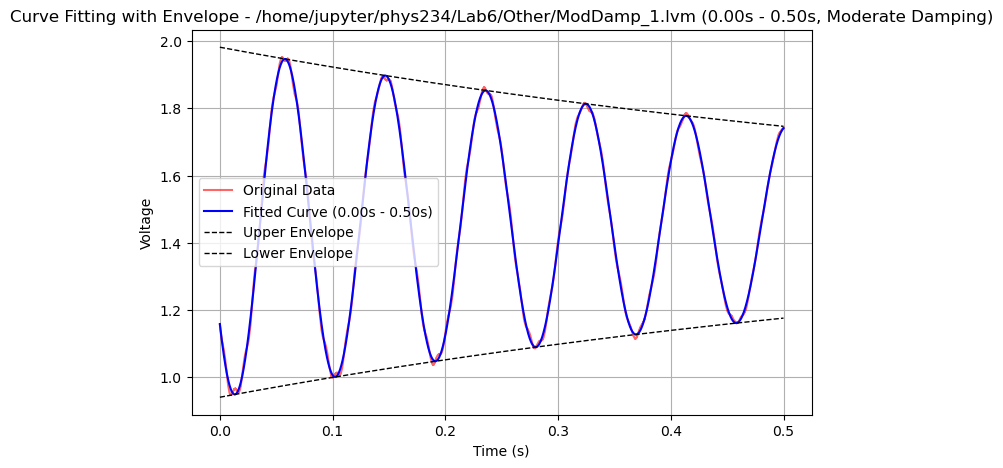

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_1.lvm (0.00s - 0.50s, Moderate Damping):
  Amplitude (A): 0.5209
  Decay Rate (γ): 1.2030
  Frequency (f0): 11.2398 Hz
  Phase (φ): 2.1916
  Offset (C): 1.4610
  Quality Factor (Q): 29.3524




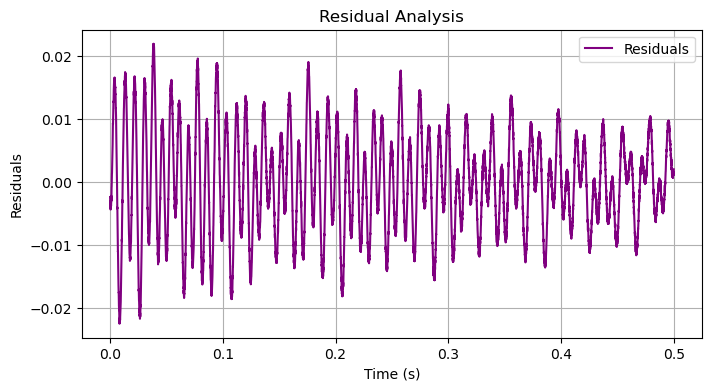

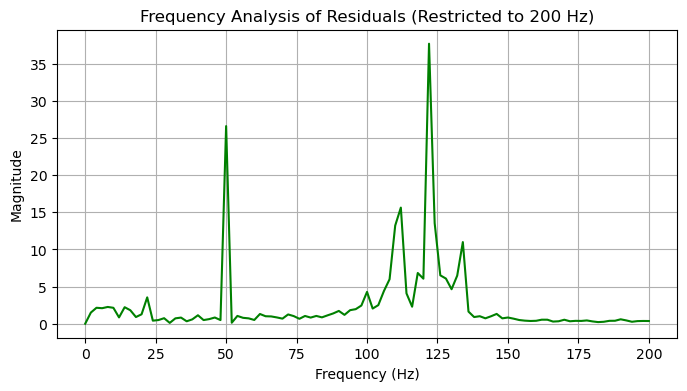

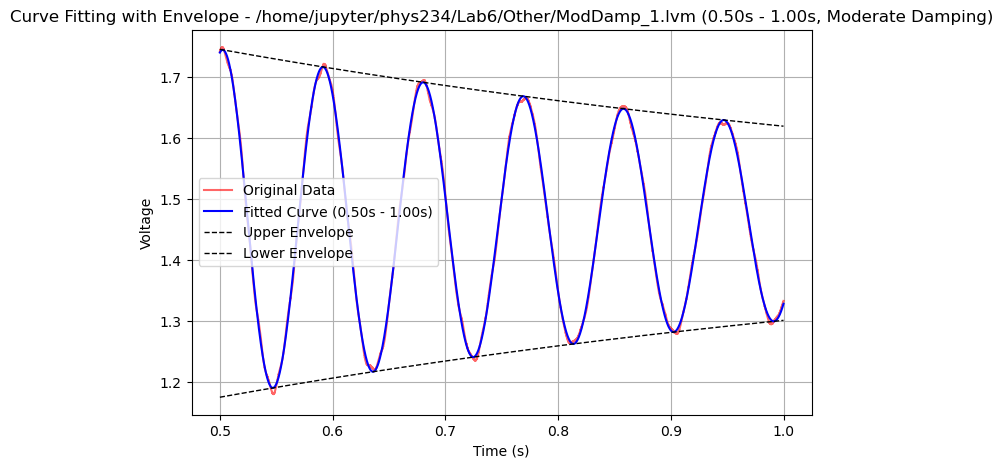

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_1.lvm (0.50s - 1.00s, Moderate Damping):
  Amplitude (A): 0.2853
  Decay Rate (γ): 1.1664
  Frequency (f0): 11.2515 Hz
  Phase (φ): -0.1936
  Offset (C): 1.4606
  Quality Factor (Q): 30.3049




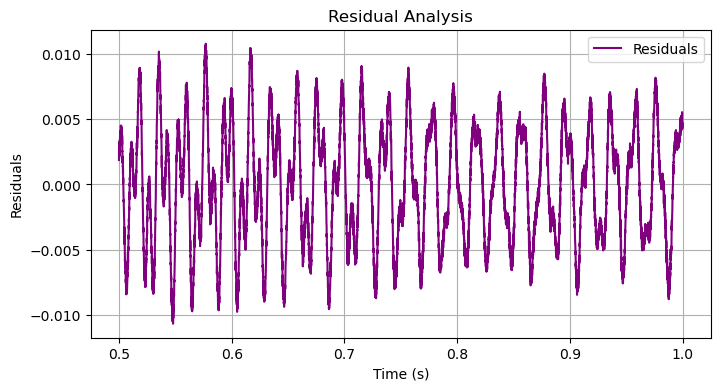

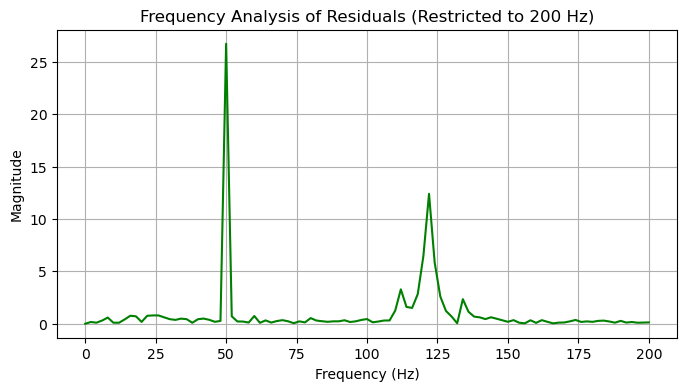

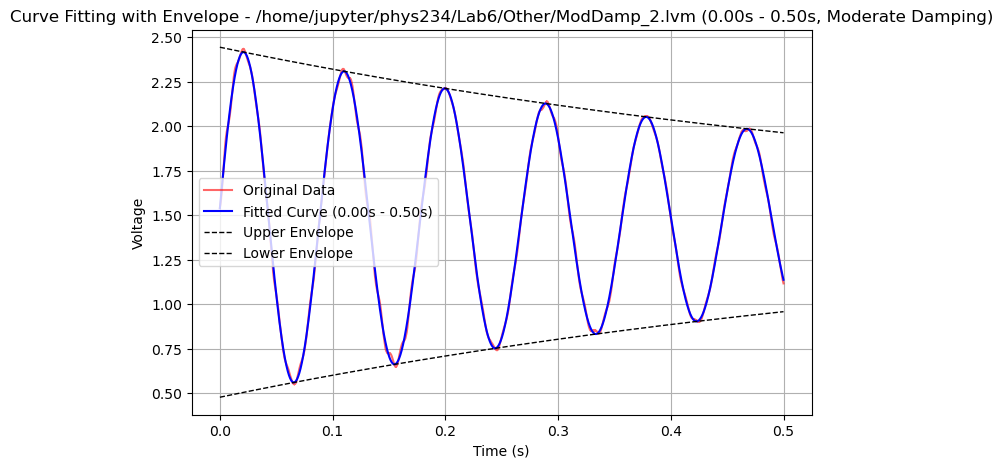

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_2.lvm (0.00s - 0.50s, Moderate Damping):
  Amplitude (A): 0.9826
  Decay Rate (γ): 1.3424
  Frequency (f0): 11.1983 Hz
  Phase (φ): -1.4910
  Offset (C): 1.4611
  Quality Factor (Q): 26.2071




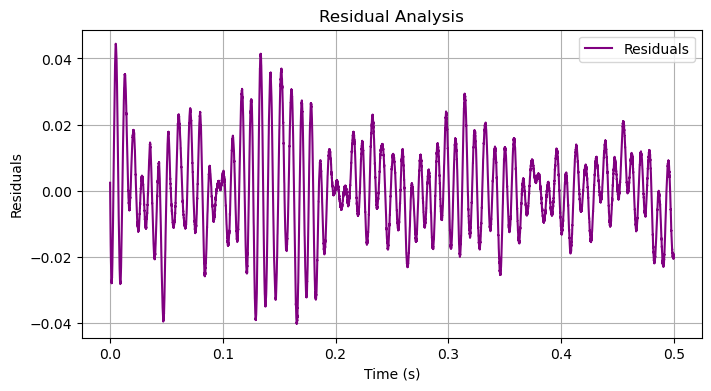

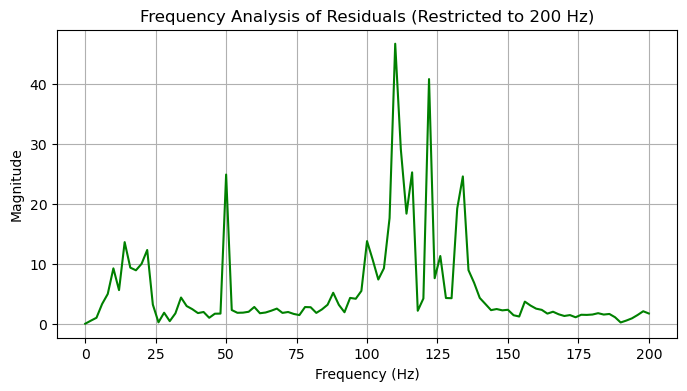

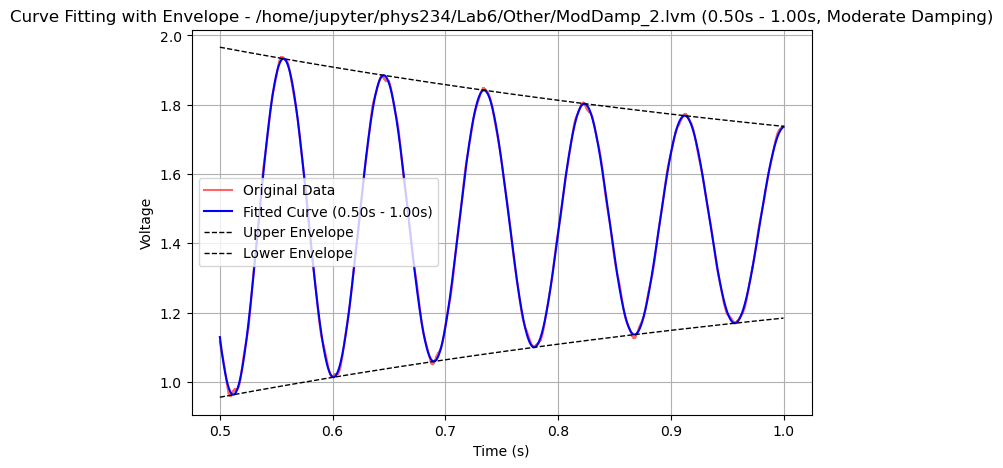

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_2.lvm (0.50s - 1.00s, Moderate Damping):
  Amplitude (A): 0.5050
  Decay Rate (γ): 1.2039
  Frequency (f0): 11.2395 Hz
  Phase (φ): 2.2864
  Offset (C): 1.4610
  Quality Factor (Q): 29.3302




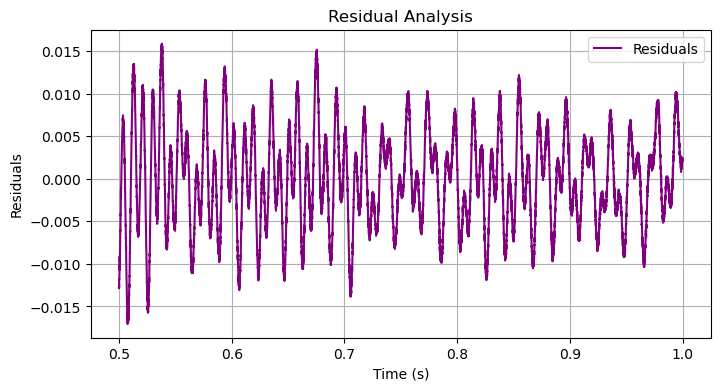

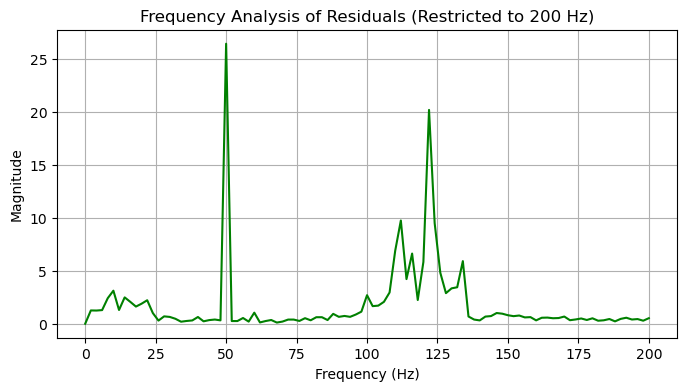

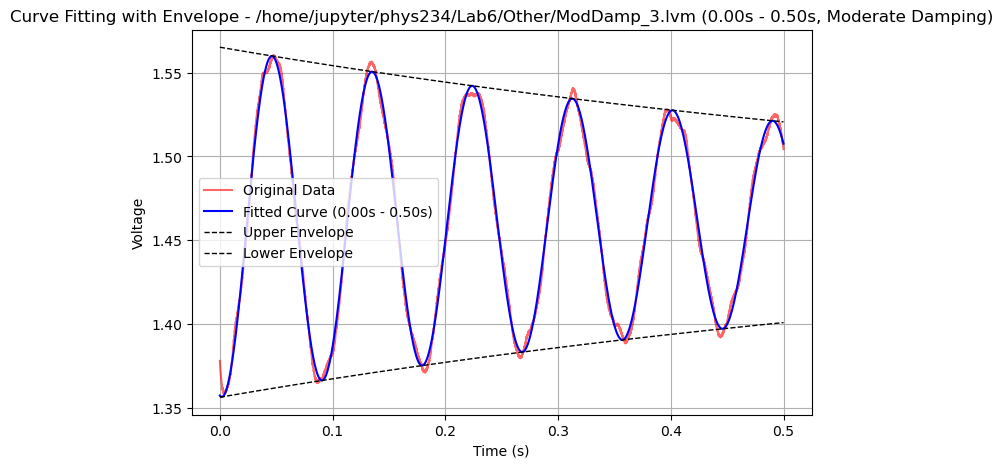

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_3.lvm (0.00s - 0.50s, Moderate Damping):
  Amplitude (A): 0.1044
  Decay Rate (γ): 1.1122
  Frequency (f0): 11.2587 Hz
  Phase (φ): 3.0050
  Offset (C): 1.4608
  Quality Factor (Q): 31.8021




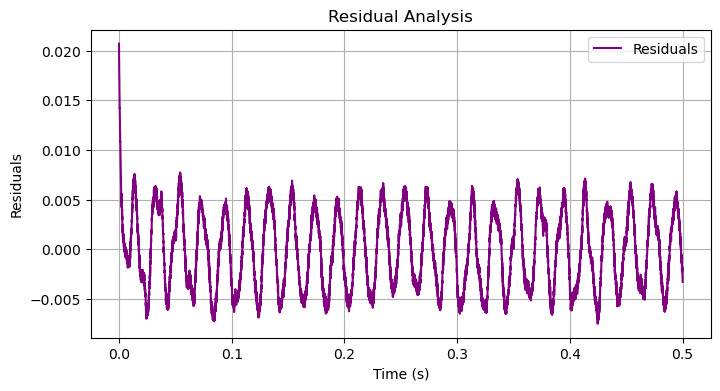

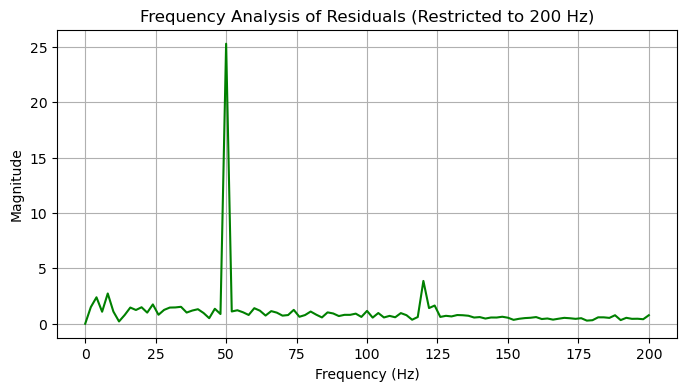

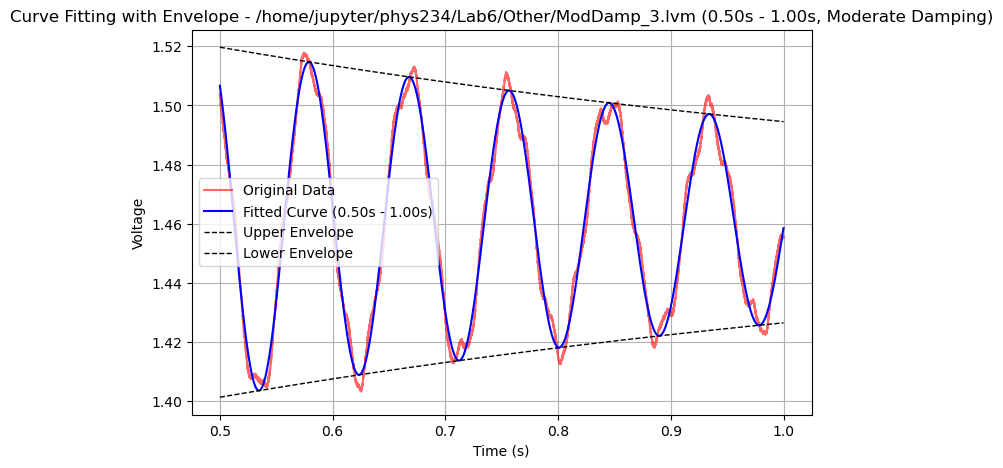

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_3.lvm (0.50s - 1.00s, Moderate Damping):
  Amplitude (A): 0.0592
  Decay Rate (γ): 1.1075
  Frequency (f0): 11.2674 Hz
  Phase (φ): 0.6761
  Offset (C): 1.4605
  Quality Factor (Q): 31.9624




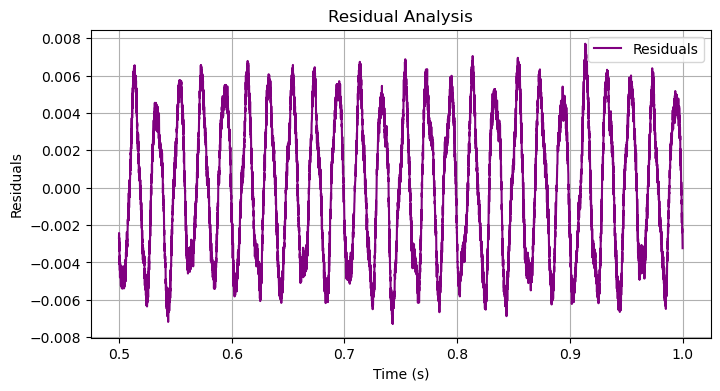

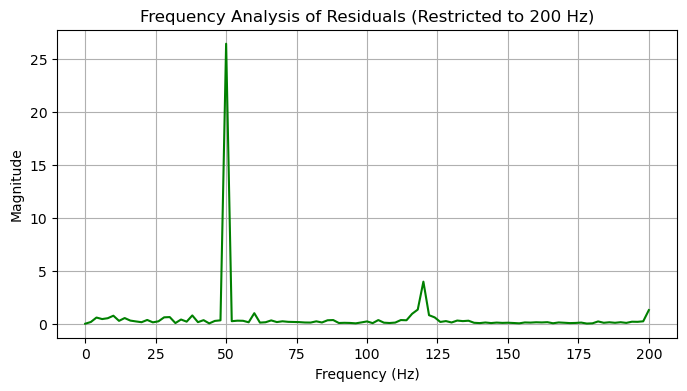

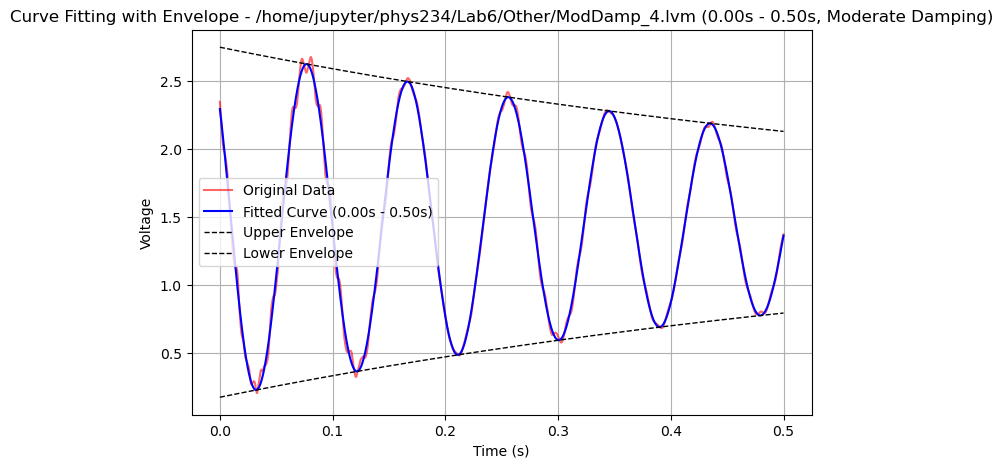

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_4.lvm (0.00s - 0.50s, Moderate Damping):
  Amplitude (A): 1.2844
  Decay Rate (γ): 1.3120
  Frequency (f0): 11.1780 Hz
  Phase (φ): 0.8670
  Offset (C): 1.4623
  Quality Factor (Q): 26.7655




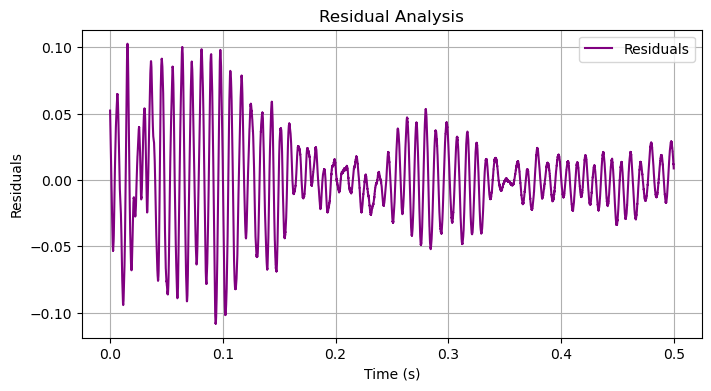

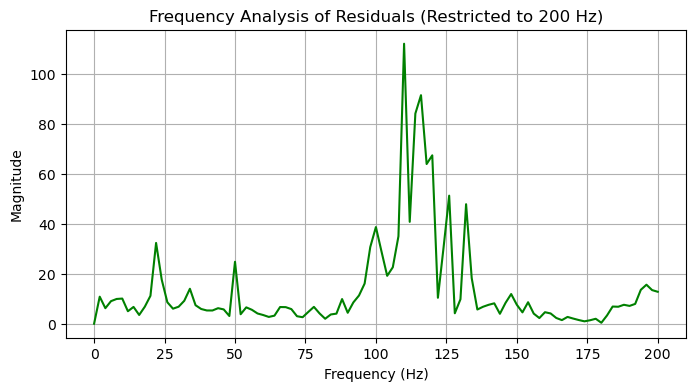

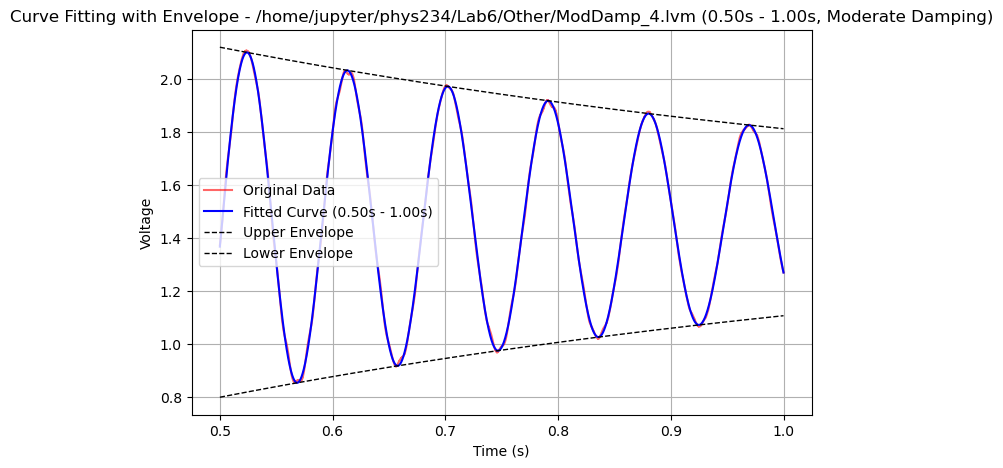

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_4.lvm (0.50s - 1.00s, Moderate Damping):
  Amplitude (A): 0.6604
  Decay Rate (γ): 1.2538
  Frequency (f0): 11.2265 Hz
  Phase (φ): -1.7109
  Offset (C): 1.4609
  Quality Factor (Q): 28.1293




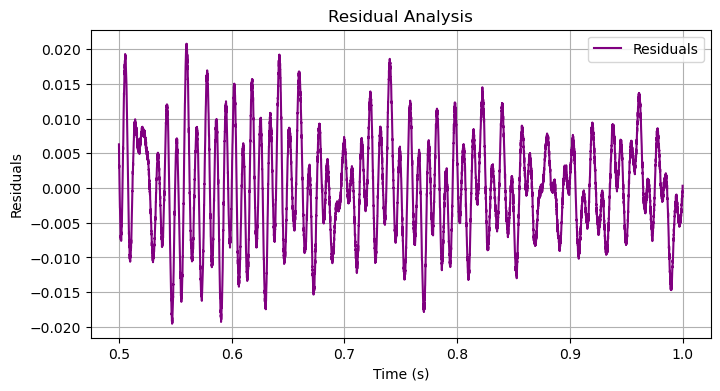

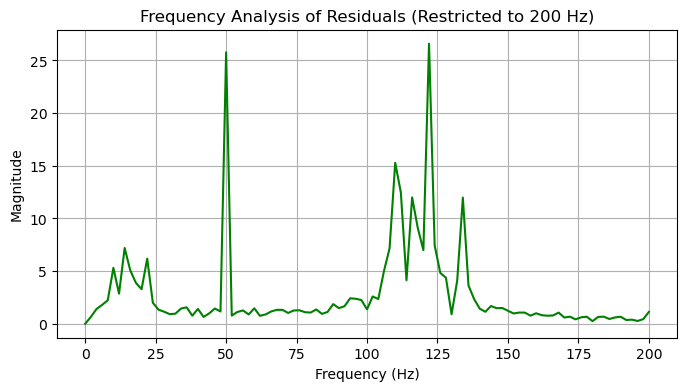

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import os

# Define file paths for Moderate Damping
moderate_damp_files = ["ModDamp_1.lvm", "ModDamp_2.lvm", "ModDamp_3.lvm", "ModDamp_4.lvm"]
data_dir = "/home/jupyter/phys234/Lab6/Other/"  # Adjust as needed
moderate_damp_files = [os.path.join(data_dir, fname) for fname in moderate_damp_files]

# Function to load data from .lvm files
def load_data(file):
    return pd.read_csv(file, sep="\t", names=["Time", "Value1", "Value2"])

# Function to define an exponentially decaying sine wave model
def damped_sine_wave(t, A, gamma, omega, phi, C):
    return A * np.exp(-gamma * (t - t[0])) * np.cos(omega * (t - t[0]) + phi) + C

# Function to compute Q using Q = omega / (2 * gamma)
def calculate_Q(omega, gamma):
    if omega is None or gamma is None or gamma <= 0:
        return None
    return omega / (2 * gamma)

# Function to estimate frequency using FFT and peak detection
def estimate_frequency(time, values):
    if len(values) < 10:
        return 2 * np.pi
    dt = np.mean(np.diff(time))
    n = len(values)

    freqs = fftfreq(n, dt)
    fft_values = np.abs(fft(values))

    peak_indices, _ = find_peaks(fft_values[:n // 2])
    if len(peak_indices) == 0:
        return 2 * np.pi

    dominant_freq = freqs[peak_indices[np.argmax(fft_values[peak_indices])]]
    return max(abs(dominant_freq * 2 * np.pi), 2 * np.pi)

# Function to estimate decay rate using logarithmic regression
def estimate_decay_rate(time, values):
    peak_indices, _ = find_peaks(values)
    if len(peak_indices) < 5:
        return 0.1

    peak_times = time[peak_indices]
    peak_values = values[peak_indices]

    log_values = np.log(np.abs(peak_values))

    slope, _ = np.polyfit(peak_times, log_values, 1)
    return abs(slope) if slope > 0 else 0.1

# Function to remove outliers using z-score filtering
def remove_outliers(values, threshold=3):
    median = np.median(values)
    deviation = np.abs(values - median)
    mad = np.median(deviation)
    if mad == 0:
        return values

    z_scores = deviation / mad
    return values[z_scores < threshold]

# Function to divide dataset into slices with 0.5-second intervals
def get_slices(df, slice_duration=0.5):
    start_time = df["Time"].min()
    end_time = df["Time"].max()

    slice_times = np.arange(start_time, end_time, slice_duration)
    slices = []

    for t in slice_times:
        segment = df[(df["Time"] >= t) & (df["Time"] < t + slice_duration)].copy()
        if len(segment) > 10:
            slices.append((segment, f"{t:.2f}s - {t + slice_duration:.2f}s"))

    return slices

# Function to perform frequency analysis of residuals (restricted to 200 Hz)
def analyze_residuals(time, residuals):
    if len(residuals) < 10:
        return  

    dt = np.mean(np.diff(time))
    n = len(residuals)

    freqs = fftfreq(n, dt)
    fft_values = np.abs(fft(residuals))

    # Restrict range to 200 Hz
    mask = (freqs >= 0) & (freqs <= 200)
    freqs_zoomed = freqs[mask]
    fft_values_zoomed = fft_values[mask]

    # Plot residuals
    plt.figure(figsize=(8, 4))
    plt.plot(time, residuals, label="Residuals", color="purple")
    plt.xlabel("Time (s)")
    plt.ylabel("Residuals")
    plt.title("Residual Analysis")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot frequency analysis of residuals
    plt.figure(figsize=(8, 4))
    plt.plot(freqs_zoomed, fft_values_zoomed, color="green")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("Frequency Analysis of Residuals (Restricted to 200 Hz)")
    plt.grid()
    plt.show()

# Function to fit decay data for each time slice
def fit_and_analyze(file_paths, damping_type):
    for file in file_paths:
        df = load_data(file)
        df = df.sort_values(by="Time")

        slices = get_slices(df, slice_duration=0.5)

        for segment, label in slices:
            try:
                time = segment["Time"].values
                values = segment["Value1"].values

                # Remove outliers
                values = remove_outliers(values)

                # Estimate frequency and decay rate dynamically
                estimated_omega = estimate_frequency(time, values)
                estimated_gamma = estimate_decay_rate(time, values)

                # Adaptive initial guesses
                A_guess = max(np.ptp(values) / 2, 0.001)
                phi_guess = 0
                C_guess = np.mean(values)

                # Fit the damped sine wave
                popt, _ = curve_fit(
                    damped_sine_wave,
                    time, values,
                    p0=[A_guess, estimated_gamma, estimated_omega, phi_guess, C_guess],
                    bounds=([0, 0, 0, -np.pi, -np.inf], [np.inf, np.inf, np.inf, np.pi, np.inf]),
                    maxfev=50000
                )

                A, gamma, omega, phi, C = popt
                f0 = max(omega / (2 * np.pi), 0)
                Q = calculate_Q(omega, gamma)

                # Compute fitted values and residuals
                fitted_values = damped_sine_wave(time, *popt)
                residuals = values - fitted_values

                # Compute upper and lower envelope
                envelope_upper = A * np.exp(-gamma * (time - time[0])) + C
                envelope_lower = -A * np.exp(-gamma * (time - time[0])) + C

                # Plot with envelopes
                plt.figure(figsize=(8, 5))
                plt.plot(time, values, label="Original Data", color="red", alpha=0.6)
                plt.plot(time, fitted_values, label=f"Fitted Curve ({label})", color="blue")
                plt.plot(time, envelope_upper, 'k--', label="Upper Envelope", linewidth=1)
                plt.plot(time, envelope_lower, 'k--', label="Lower Envelope", linewidth=1)
                plt.xlabel("Time (s)")
                plt.ylabel("Voltage")
                plt.legend()
                plt.title(f"Curve Fitting with Envelope - {file} ({label}, {damping_type} Damping)")
                plt.grid()
                plt.show()

                print(f"Fitted Parameters for {file} ({label}, {damping_type} Damping):")
                print(f"  Amplitude (A): {A:.4f}")
                print(f"  Decay Rate (γ): {gamma:.4f}")
                print(f"  Frequency (f0): {f0:.4f} Hz")
                print(f"  Phase (φ): {phi:.4f}")
                print(f"  Offset (C): {C:.4f}")
                print(f"  Quality Factor (Q): {'N/A' if Q is None else Q:.4f}")
                print("\n")

                # Analyze residuals
                analyze_residuals(time, residuals)

            except Exception as e:
                print(f"Error processing {file} ({label}): {e}")

# Run analysis for Moderate Damping only
fit_and_analyze(moderate_damp_files, "Moderate")


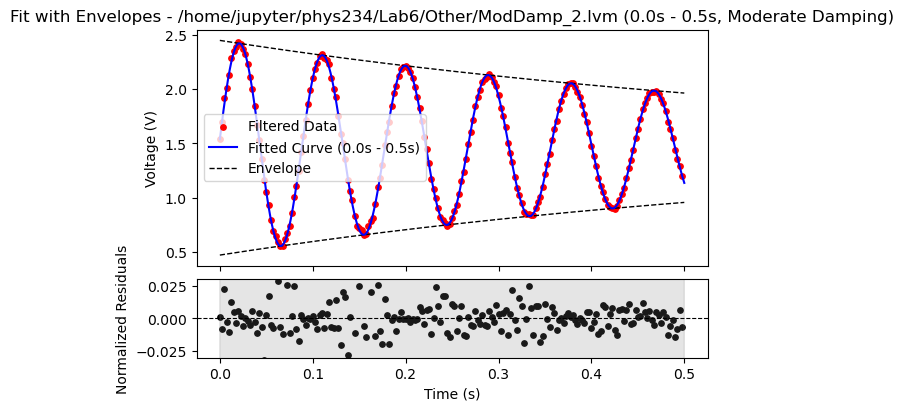

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_2.lvm (0.0s - 0.5s, Moderate Damping):
  Amplitude (A): 0.9861
  Decay Rate (γ): 1.3493
  Frequency (f0): 11.1978 Hz
  Phase (φ): -1.4900
  Offset (C): 1.4607
  Quality Factor (Q): 26.0714




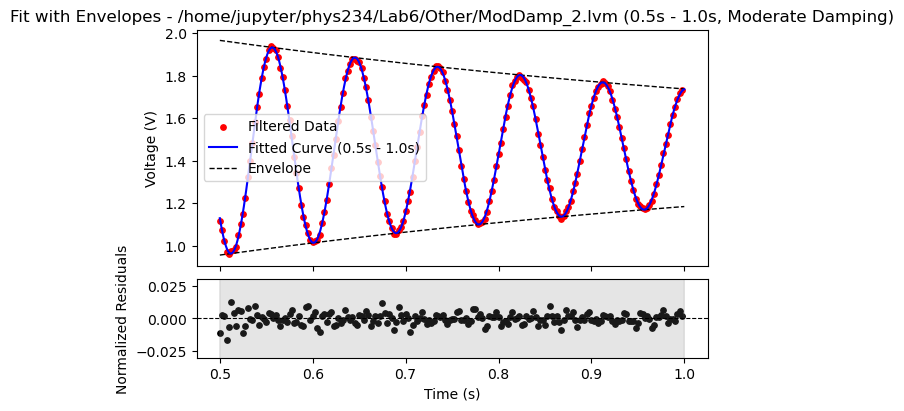

Fitted Parameters for /home/jupyter/phys234/Lab6/Other/ModDamp_2.lvm (0.5s - 1.0s, Moderate Damping):
  Amplitude (A): 0.5050
  Decay Rate (γ): 1.2035
  Frequency (f0): 11.2396 Hz
  Phase (φ): 2.2867
  Offset (C): 1.4610
  Quality Factor (Q): 29.3401




In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, find_peaks
import os

mod_damp_files = ["ModDamp.lvm", "ModDamp_1.lvm", "ModDamp_2.lvm", "ModDamp_3.lvm", "ModDamp_4.lvm"]
data_dir = "/home/jupyter/phys234/Lab6/Other/"  # Adjust as needed
mod_damp_files = [os.path.join(data_dir, fname) for fname in mod_damp_files]



def load_data(file):
    return pd.read_csv(file, sep="\t", names=["Time", "Value1", "Value2"])

def low_pass_filter(data, cutoff=50, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return filtfilt(b, a, data)

def damped_sine_wave(t, A, gamma, omega, phi, C):
    return A * np.exp(-gamma * (t - t[0])) * np.cos(omega * (t - t[0]) + phi) + C

def calculate_Q(omega, gamma):
    if omega <= 0 or gamma <= 0:
        return np.nan
    return omega / (2 * gamma)

def estimate_frequency(time, values):
    dt = np.mean(np.diff(time))
    freqs = fftfreq(len(values), dt)
    fft_values = np.abs(fft(values))
    peak_indices, _ = find_peaks(fft_values[:len(values)//2])
    if len(peak_indices) == 0:
        return 2 * np.pi
    dominant_freq = freqs[peak_indices[np.argmax(fft_values[peak_indices])]]
    return abs(dominant_freq * 2 * np.pi)

def get_slices(df, slice_duration=0.5, time_limit=1.0):
    start_time = df["Time"].min()
    end_time = min(df["Time"].max(), start_time + time_limit)
    slices = []
    for t in np.arange(start_time, end_time, slice_duration):
        segment = df[(df["Time"] >= t) & (df["Time"] < t + slice_duration)]
        if len(segment) > 10:
            slices.append((segment, f"{t:.1f}s - {t+slice_duration:.1f}s"))
    return slices

def plot_with_residuals(time, values, fitted_values, envelope_upper, envelope_lower, norm_residuals, file, label, damping_type):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), height_ratios=[3, 1], constrained_layout=True)
    sample_size = 50
    s = 15

    # Upper plot: Filtered data as points, fit as a line
    axs[0].scatter(time[::sample_size], values[::sample_size], color="red", s=s, label="Filtered Data", zorder=1)
    axs[0].plot(time, fitted_values, color="blue", label=f"Fitted Curve ({label})", zorder=2)
    axs[0].plot(time, envelope_upper, 'k--', label="Envelope", linewidth=1, zorder=1)
    axs[0].plot(time, envelope_lower, 'k--', linewidth=1, zorder=1)

    axs[0].set_ylabel("Voltage (V)")
    axs[0].legend()
    axs[0].set_title(f"Fit with Envelopes - {file} ({label}, {damping_type} Damping)")
    axs[0].tick_params(labelbottom=False)  # Hide x-axis labels on upper plot

    # Lower plot: Normalized residuals as points
    axs[1].scatter(time[::sample_size], norm_residuals[::sample_size], color='black', s=s)
    axs[1].axhline(0, color='k', linestyle='--', linewidth=0.8)
    axs[1].fill_between(time, -1, 1, color='gray', alpha=0.2)
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Normalized Residuals")
    axs[1].set_ylim(-0.03, 0.03)

    if not os.path.exists("saved_figures"):
        os.makedirs("saved_figures")

    fig_name = f"saved_figures/{file.replace('.lvm', '').replace('/', '_')}_{label.replace(' ', '_')}.pdf"
    plt.savefig(fig_name)
    plt.show()



def fit_and_analyze(file_paths, damping_type, slice_duration=0.5, time_limit=1.0):
    for file in file_paths:
        df = load_data(file).sort_values(by="Time")

        slices = get_slices(df, slice_duration, time_limit)

        for segment, label in slices:
            try:
                time = segment["Time"].values
                values = segment["Value1"].values
                values = low_pass_filter(values, cutoff=50, fs=1000)

                estimated_omega = estimate_frequency(time, values)

                A_guess = np.ptp(values) / 2
                gamma_guess = 0.05 if A_guess > 0.1 else 0.1
                phi_guess = 0
                C_guess = np.mean(values)

                weights = 1 / (np.abs(values) + 1e-3)

                popt, _ = curve_fit(
                    damped_sine_wave, time, values,
                    p0=[A_guess, gamma_guess, estimated_omega, phi_guess, C_guess],
                    bounds=([0, 0, 0, -np.pi, -np.inf], [np.inf, np.inf, np.inf, np.pi, np.inf]),
                    sigma=weights,
                    maxfev=50000
                )

                A, gamma, omega, phi, C = popt
                f0 = omega / (2 * np.pi)
                Q = calculate_Q(omega, gamma)

                fitted_values = damped_sine_wave(time, *popt)
                residuals = values - fitted_values

                envelope_upper = A * np.exp(-gamma * (time - time[0])) + C
                envelope_lower = -A * np.exp(-gamma * (time - time[0])) + C

                # Calculate normalized residuals
                uncertainties = 1 / weights
                norm_residuals = residuals / uncertainties

                plot_with_residuals(
                    time, values, fitted_values,
                    envelope_upper, envelope_lower,
                    norm_residuals, file, label, damping_type
                )

                print(f"Fitted Parameters for {file} ({label}, {damping_type} Damping):")
                print(f"  Amplitude (A): {A:.4f}")
                print(f"  Decay Rate (γ): {gamma:.4f}")
                print(f"  Frequency (f0): {f0:.4f} Hz")
                print(f"  Phase (φ): {phi:.4f}")
                print(f"  Offset (C): {C:.4f}")
                print(f"  Quality Factor (Q): {Q:.4f}")
                print("\n")

                
                # Ensure directory exists
                processed_data_dir = "/home/jupyter/phys234/Lab6/ProcessedData"
                if not os.path.exists(processed_data_dir):
                    os.makedirs(processed_data_dir)
                
                # Save data to file
                save_file_path = os.path.join(processed_data_dir, f"Transient_fit_ModDamping_data.txt")
                np.savetxt(
                    save_file_path,
                    np.column_stack((time, values, fitted_values, norm_residuals)),
                    header="Time(s)\tFilteredVoltage(V)\tFittedVoltage(V)\tNormalizedResiduals",
                    delimiter="\t",
                    fmt="%.6e"
                )


            except Exception as e:
                print(f"Error processing {file} ({label}): {e}")



#fit_and_analyze(max_damp_files, "Moderate", slice_duration=0.5, time_limit=1.0)
fit_and_analyze([mod_damp_files[2]], "Moderate", slice_duration=0.5, time_limit=1.0)




